2.  Use partition pairs of the form P = (1, b1/n, b2/n, . . . , b) and T = (1, b1/n, b2/n, . . . , b(n−1)/n) to
analytically compute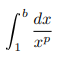
x
p
for b, > 1.
3

,n,power int (sum),power int (closed),power int (exact),power |error|
0,10,0.774626,0.774626,0.639242,0.135384
1,20,0.703868,0.703868,0.639242,0.064626
2,50,0.664389,0.664389,0.639242,0.025147
3,100,0.651701,0.651701,0.639242,0.012459
4,200,0.645443,0.645443,0.639242,0.006201
5,500,0.641716,0.641716,0.639242,0.002474
6,1000,0.640478,0.640478,0.639242,0.001236
7,3000,0.639654,0.639654,0.639242,0.000412
8,10000,0.639366,0.639366,0.639242,0.000123


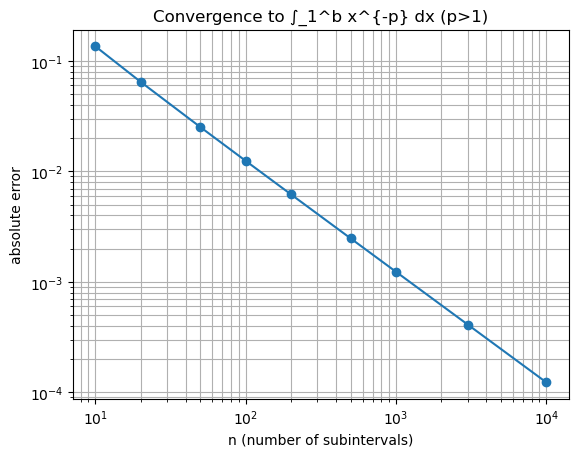

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log

def riemann_ln(a: float, n: int) -> float:
    """Riemann sum for ∫_1^a (1/x) dx with geometric partition."""
    k = np.arange(1, n + 1)
    t_k = a ** ((k - 1) / n)                  # tags
    delta_x = a ** (k / n) - a ** ((k - 1) / n)
    return np.sum((1.0 / t_k) * delta_x)

def riemann_ln_closed(a: float, n: int) -> float:
    """Same sum but simplified algebraically to n*(a^{1/n} - 1)."""
    return n * (a ** (1.0 / n) - 1.0)

def riemann_power(b: float, p: float, n: int) -> float:
    """Riemann sum for ∫_1^b x^{-p} dx (b>1, p>1) with geometric partition."""
    k = np.arange(1, n + 1)
    t_k = b ** ((k - 1) / n)
    delta_x = b ** (k / n) - b ** ((k - 1) / n)
    return np.sum((t_k ** (-p)) * delta_x)

def riemann_power_closed(b: float, p: float, n: int) -> float:
    """Closed-form of the geometric-partition sum via a geometric series."""
    num = (b ** (1.0 / n) - 1.0) * (1.0 - b ** (1.0 - p))
    den = 1.0 - b ** ((1.0 - p) / n)
    return num / den

b = 5.0         # for power integral demo
p = 2.4         # p>1
n_values = [10, 20, 50, 100, 200, 500, 1000, 3000, 10000]

rows = []
for n in n_values:
    exact_pow = (1.0 - b ** (1.0 - p)) / (p - 1.0)

    approx_pow = riemann_power(b, p, n)
    approx_pow_closed = riemann_power_closed(b, p, n)

    rows.append({
        "n": n,
        "power int (sum)": approx_pow,
        "power int (closed)": approx_pow_closed,
        "power int (exact)": exact_pow,
        "power |error|": abs(approx_pow - exact_pow),
    })

df = pd.DataFrame(rows).round(10)
display(df)              
ns = np.array(n_values, dtype=float)

errors_pow = np.array([abs(riemann_power(b, p, n) - ((1.0 - b ** (1.0 - p)) / (p - 1.0))) for n in n_values], dtype=float)
plt.figure()
plt.loglog(ns, errors_pow, marker="o")
plt.xlabel("n (number of subintervals)")
plt.ylabel("absolute error")
plt.title("Convergence to ∫_1^b x^{-p} dx (p>1)")
plt.grid(True, which="both")
plt.show()

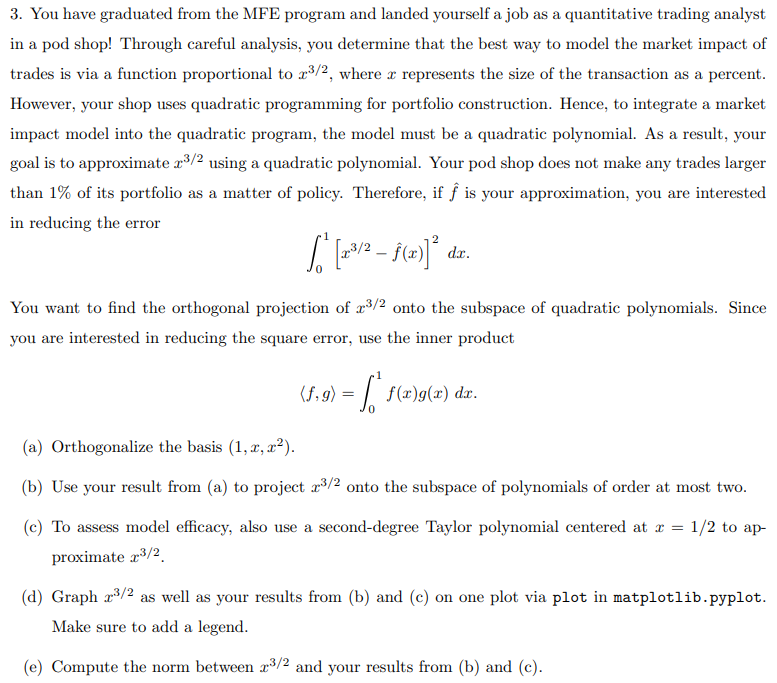

In [2]:
import sympy as sp

x = sp.symbols('x')
f = x**(sp.Rational(3,2))

def inner(g,h):
    return sp.integrate(g*h, (x,0,1))

basis = [1, x, x**2]
orth = []
for v in basis:
    w = v
    for u in orth:
        w -= inner(v,u)/inner(u,u) * u
    orth.append(sp.simplify(w))

orth  # orthogonal basis functions

[1, x - 1/2, x**2 - x + 1/6]

In [3]:
proj = 0
for v in orth:
    proj += (inner(f,v)/inner(v,v)) * v
proj = sp.expand(proj)

proj

4*x**2/7 + 16*x/35 - 2/105

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# (c) Second-degree Taylor at x0 = 1/2
x0 = sp.Rational(1,2)
T2 = ( f.subs(x,x0)
       + sp.diff(f,x).subs(x,x0)*(x-x0)
       + sp.diff(f,x,2).subs(x,x0)/2 * (x-x0)**2 )
T2 = sp.simplify(sp.expand(T2))  # gives sqrt(2)*(12x^2+12x-1)/32

T2

sqrt(2)*(12*x**2 + 12*x - 1)/32

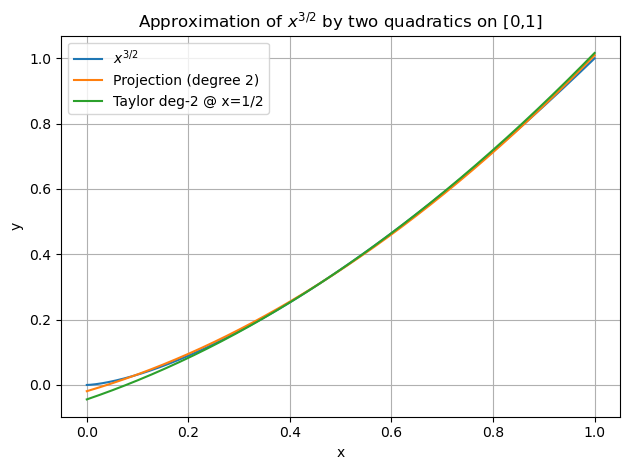

In [10]:
# (d) Lambdify for plotting
f_np   = sp.lambdify(x, f, 'numpy')
proj_np = sp.lambdify(x, proj, 'numpy')
T2_np   = sp.lambdify(x, T2, 'numpy')

# Plot on [0, 1]
xs = np.linspace(0, 1, 400)
plt.figure()
plt.plot(xs, f_np(xs),   label=r"$x^{3/2}$")
plt.plot(xs, proj_np(xs), label="Projection (degree 2)")
plt.plot(xs, T2_np(xs),   label="Taylor deg-2 @ x=1/2")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Approximation of $x^{3/2}$ by two quadratics on [0,1]")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

In [11]:
#(e) Norms of the error
def L2_norm_exact(g):
    err_sq = sp.integrate(sp.simplify(g**2), (x,0,1))
    return sp.sqrt(sp.simplify(err_sq))

norm_proj_sym = L2_norm_exact(f - proj)
norm_T2_sym   = L2_norm_exact(f - T2)

print("‖f - proj‖ (exact) =", norm_proj_sym, "≈", sp.N(norm_proj_sym))
print("‖f - T2‖   (exact) =", norm_T2_sym,   "≈", sp.N(norm_T2_sym))
print("ratio (T2/proj) ≈", float(sp.N(norm_T2_sym / norm_proj_sym)))

# numeric check with trapezoid rule
f_np   = sp.lambdify(x, f, 'numpy')
proj_np= sp.lambdify(x, proj, 'numpy')
T2_np  = sp.lambdify(x, T2, 'numpy')

xs = np.linspace(0, 1, 10001)
def L2_norm_numeric(gvals):
    return np.sqrt(np.trapz(gvals**2, xs))

err_proj_num = L2_norm_numeric(f_np(xs) - proj_np(xs))
err_T2_num   = L2_norm_numeric(f_np(xs) - T2_np(xs))

print("\nNumeric check:")
print("‖f - proj‖ ≈", err_proj_num)
print("‖f - T2‖   ≈", err_T2_num)

‖f - proj‖ (exact) = 1/210 ≈ 0.00476190476190476
‖f - T2‖   (exact) = sqrt(1289/2560 - 299*sqrt(2)/840) ≈ 0.0110878446123812
ratio (T2/proj) ≈ 2.3284473686000444

Numeric check:
‖f - proj‖ ≈ 0.004761906442178532
‖f - T2‖   ≈ 0.011087846476324308
